In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Load dataset
from google.colab import files

uploaded = files.upload()

Saving detailed_avian_disease_dataset.csv to detailed_avian_disease_dataset.csv


In [ ]:

# Display basic info
# Get the file path
file_path = list(uploaded.keys())[0]
df = pd.read_csv(file_path)
display(df.head())
display(df.info())
display(df.describe())

,Date,Region,Species,Disease,Outcome Status,Number of Cases,Age of Birds,Severity of Disease,Diagnosis Method,Owner Type,Vaccination Status,Outcome (Recovery or Mortality),Veterinarian
0,2015-07-31 00:00:00,Gloucestershire,Quail,Coccidiosis,Confirmed,44,Adult,Mild,Necropsy,Smallholder,Yes,Recovery,Dr. Johnson
1,2021-12-31 00:00:00,Devon,Wild Birds,Avian Influenza,Confirmed,37,Adult,Severe,Rapid Test,Commercial Farm,No,Mortality,Dr. Smith
2,2014-09-30 00:00:00,Glamorgan,Turkeys,Marek's disease,Confirmed,42,Juvenile,Moderate,PCR,Commercial Farm,Yes,Recovery,Dr. Smith
3,2008-03-31 00:00:00,Cumbria,Ducks,Marek's disease,Confirmed,4,Old,Mild,ELISA,Smallholder,No,Mortality,Dr. Brown
4,2015-11-30 00:00:00,Strathclyde,Geese,Egg Drop Syndrome,No Diagnosis,9,Old,Severe,ELISA,Smallholder,No,Mortality,Dr. Lee


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Date                             50000 non-null  object
 1   Region                           50000 non-null  object
 2   Species                          50000 non-null  object
 3   Disease                          50000 non-null  object
 4   Outcome Status                   50000 non-null  object
 5   Number of Cases                  50000 non-null  int64 
 6   Age of Birds                     50000 non-null  object
 7   Severity of Disease              50000 non-null  object
 8   Diagnosis Method                 50000 non-null  object
 9   Owner Type                       50000 non-null  object
 10  Vaccination Status               50000 non-null  object
 11  Outcome (Recovery or Mortality)  50000 non-null  object
 12  Veterinarian                    

None

,Number of Cases
count,50000.000000
mean,25.100300
std,14.150113
min,1.000000
25%,13.000000
50%,25.000000
75%,37.000000
max,49.000000


In [ ]:

# Drop missing values
df.dropna(inplace=True)


In [ ]:

# Step 1: Data Preprocessing

# Convert 'Date' to datetime and extract useful features like Year and Month
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Drop the original 'Date' and 'Veterinarian' (assuming not useful for prediction)
df = df.drop(columns=['Date', 'Veterinarian'])
display(df.head())


,Region,Species,Disease,Outcome Status,Number of Cases,Age of Birds,Severity of Disease,Diagnosis Method,Owner Type,Vaccination Status,Outcome (Recovery or Mortality),Year,Month
0,Gloucestershire,Quail,Coccidiosis,Confirmed,44,Adult,Mild,Necropsy,Smallholder,Yes,Recovery,2015,7
1,Devon,Wild Birds,Avian Influenza,Confirmed,37,Adult,Severe,Rapid Test,Commercial Farm,No,Mortality,2021,12
2,Glamorgan,Turkeys,Marek's disease,Confirmed,42,Juvenile,Moderate,PCR,Commercial Farm,Yes,Recovery,2014,9
3,Cumbria,Ducks,Marek's disease,Confirmed,4,Old,Mild,ELISA,Smallholder,No,Mortality,2008,3
4,Strathclyde,Geese,Egg Drop Syndrome,No Diagnosis,9,Old,Severe,ELISA,Smallholder,No,Mortality,2015,11


In [ ]:
# Convert all categorical variables to numeric using one-hot encoding
df_numeric = pd.get_dummies(df)



In [ ]:
# Display the first 10 rows of the numeric dataset
print(df_numeric.head(10))


   Number of Cases  Year  Month  Region_Aberdeenshire  Region_Cheshire  \
0               44  2015      7                 False            False   
1               37  2021     12                 False            False   
2               42  2014      9                 False            False   
3                4  2008      3                 False            False   
4                9  2015     11                 False            False   
5                1  2012     12                 False            False   
6               12  2022      9                 False             True   
7                4  2008      9                 False            False   
8                4  2015      7                  True            False   
9                9  2017      2                 False            False   

   Region_Cumbria  Region_Devon  Region_Edinburgh  Region_Fife  \
0           False         False             False        False   
1           False          True             False    

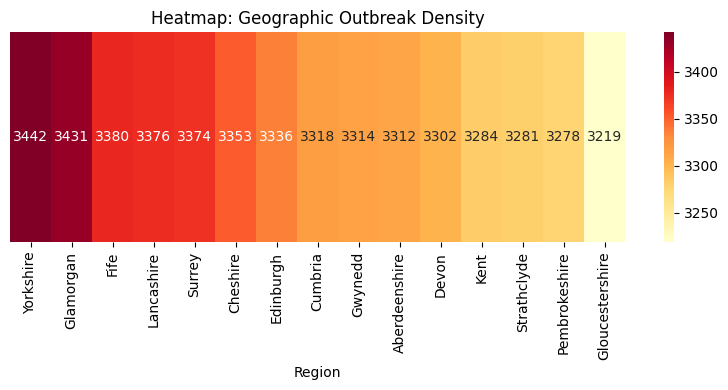

In [ ]:
# Heatmap: Geographic outbreak density
plt.figure(figsize=(8, 4))
region_counts = df['Region'].value_counts().sort_values(ascending=False)
sns.heatmap(region_counts.to_frame().T, cmap='YlOrRd', annot=True, fmt='d')
plt.title("Heatmap: Geographic Outbreak Density")
plt.yticks([])  # Remove y-axis label as it's artificial
plt.xlabel("Region")
plt.tight_layout()
plt.show()

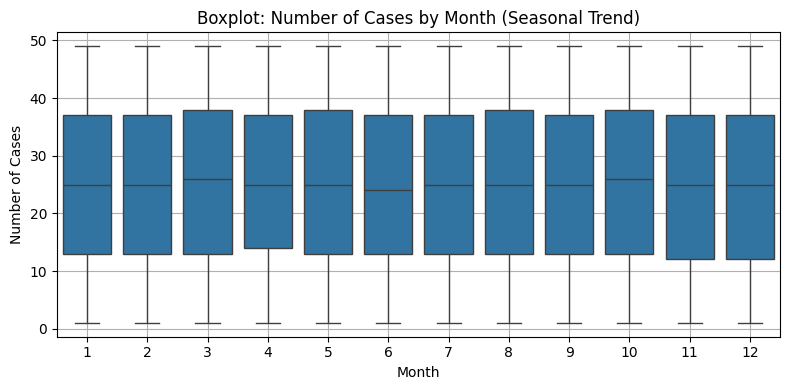

In [ ]:
#Boxplot: Outbreaks vs. Month (as a proxy for temperature)
plt.figure(figsize=(8, 4))
sns.boxplot(x='Month', y='Number of Cases', data=df)
plt.title("Boxplot: Number of Cases by Month (Seasonal Trend)")
plt.xlabel("Month")
plt.ylabel("Number of Cases")
plt.grid(True)
plt.tight_layout()
plt.show()


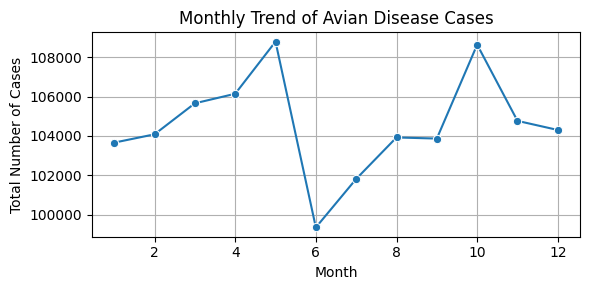

In [ ]:

# Line Chart: Monthly Trend of Cases
monthly_trend = df.groupby('Month')['Number of Cases'].sum().sort_index()
plt.figure(figsize=(6, 3))
sns.lineplot(x=monthly_trend.index, y=monthly_trend.values, marker='o')
plt.title("Monthly Trend of Avian Disease Cases")
plt.xlabel("Month")
plt.ylabel("Total Number of Cases")
plt.grid(True)
plt.tight_layout()
plt.show()

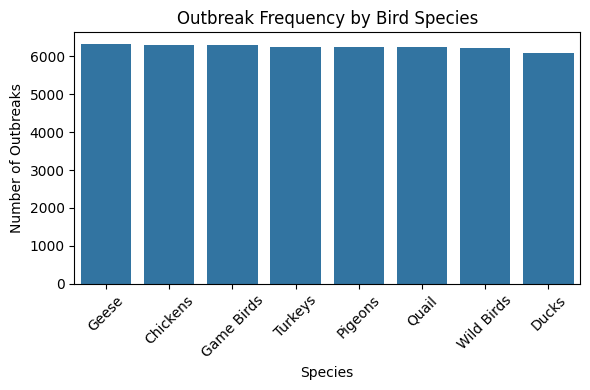

In [ ]:
# Outbreaks by Species
plt.figure(figsize=(6, 4))
species_counts = df['Species'].value_counts().sort_values(ascending=False)
sns.barplot(x=species_counts.index, y=species_counts.values)
plt.title("Outbreak Frequency by Bird Species")
plt.ylabel("Number of Outbreaks")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



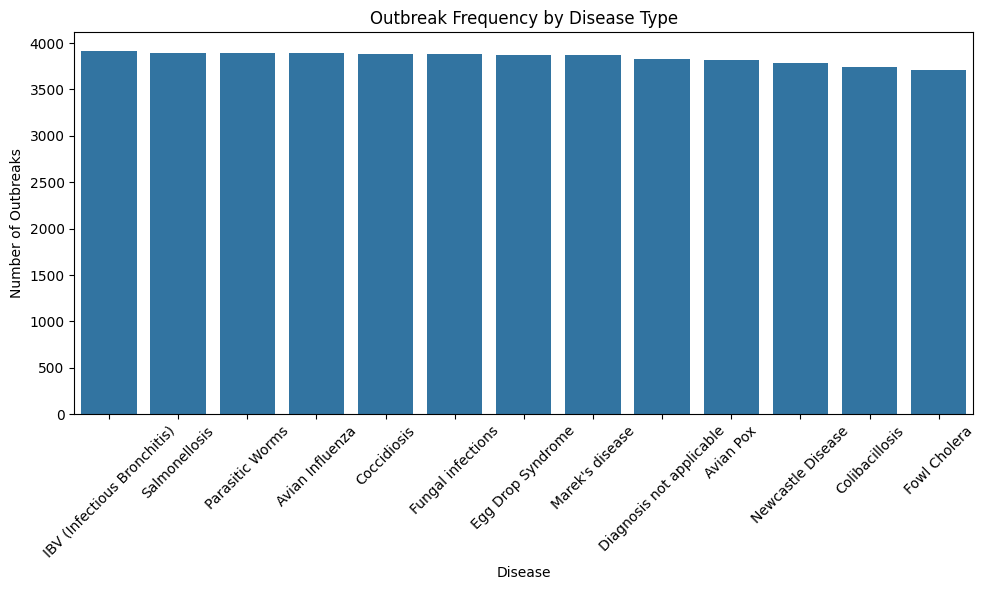

In [ ]:
# Outbreaks by Disease Type
plt.figure(figsize=(10, 6))
disease_counts = df['Disease'].value_counts().sort_values(ascending=False)
sns.barplot(x=disease_counts.index, y=disease_counts.values)
plt.title("Outbreak Frequency by Disease Type")
plt.ylabel("Number of Outbreaks")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


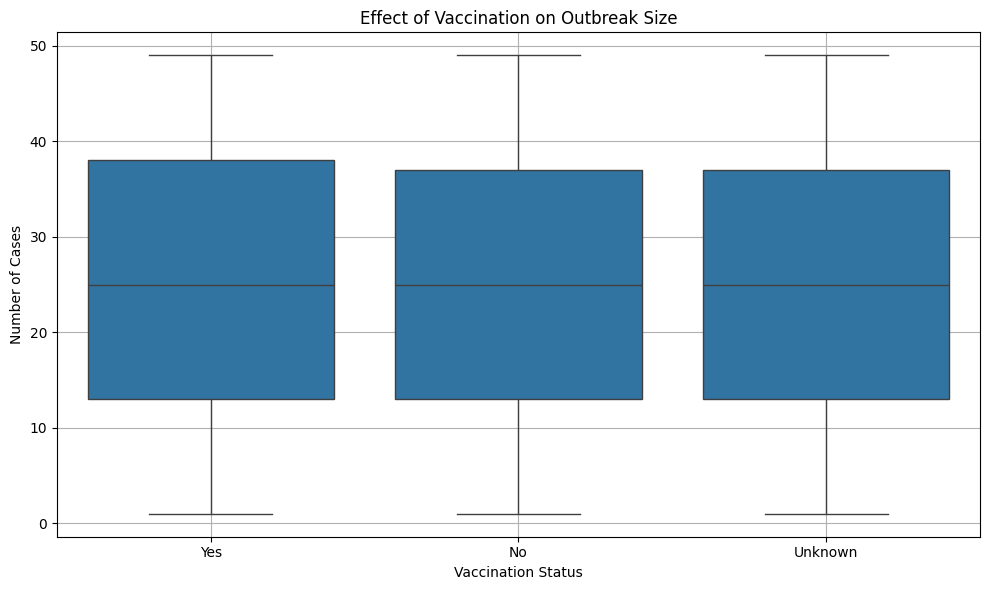

In [ ]:

# Impact of Vaccination on Outbreak Size
plt.figure(figsize=(10, 6))
sns.boxplot(x='Vaccination Status', y='Number of Cases', data=df)
plt.title("Effect of Vaccination on Outbreak Size")
plt.ylabel("Number of Cases")
plt.xlabel("Vaccination Status")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:

# Simplify dataset to avoid memory overload
df_small = df[['Month', 'Region', 'Species', 'Disease', 'Outcome Status',
               'Vaccination Status', 'Severity of Disease']].copy()



In [ ]:
# Define 'High Impact' as top 25% of 'Number of Cases'
threshold = df['Number of Cases'].quantile(0.75)
df['High Impact'] = (df['Number of Cases'] > threshold).astype(int)




In [ ]:
# Select relevant features and target
features = ['Region', 'Species', 'Disease', 'Vaccination Status', 'Outcome Status',
            'Age of Birds', 'Month', 'Year']
X = df[features]
y = df['High Impact']



In [ ]:
# One-hot encode categorical features
X_encoded = pd.get_dummies(X, drop_first=True)


In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


In [ ]:
# Train Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

accuracy, report

(0.7399,
 '              precision    recall  f1-score   support\n\n           0       0.75      0.98      0.85      7514\n           1       0.26      0.03      0.05      2486\n\n    accuracy                           0.74     10000\n   macro avg       0.51      0.50      0.45     10000\nweighted avg       0.63      0.74      0.65     10000\n')